# Build a spam classifier using Naive Bayes

In [15]:
#Headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
from wordcloud import STOPWORDS, WordCloud
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annarosejohny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annarosejohny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1:- Load your data
#### There are three datasets for training: TrainDataset1.csv, TrainDataset2.csv and TrainDataset3.txt. Each dataset contains short messages with the labels (ham or spam). Load the dataset using pandas.

In [29]:
def loadData(path,txt=False):
    """Load the dataset from the file system.
    
    Parameters
    ----------
        path:
            Path from which the data file is loaded.
        txt : defaults false.
            Boolean to check for text files.
            
    Returns
    -------
        Loaded data files as pandas dataframes for processing.
        
    """
    if txt==True:
        return pd.read_csv(path,delimiter='\t',header=None,names=["type", "text"])
    else:
        return pd.read_csv(path)

#Train data
train_df1=loadData("TrainDataset1.csv",False)
train_df2=loadData("TrainDataset2.csv",False).rename(columns={'v1': 'type', 'v2': 'text'})
train_df3=loadData("TrainDataset3.txt",True)

#Test data
test_df1=loadData("SMSSpamCollection.txt",True)
test_df2=loadData("TestDataset.csv",False).rename(columns={'v2': 'text'})

### Step 2:- Preprocess the data
#### Analyse the data, for this you will need to process the text, namely remove punctuation and stopwords, and then create a list of clean text words (Research how to do this [Hint:- see how the texts are pre-processed in Natural Language Processing]) use any libraries that you feel comfortable. Now Combine them into one big data set for the training.

In [17]:
def preProcessing(dataframe):
    """Pre-processes the actual data for further usage. Special characters, punctuations and stop words
    are removed.
    
    Parameters
    ----------
        dataframe:
            Input dataframe for pre-processing.
            
    Returns
    -------
        Pre-processed dataframe after cleaning.
              
    """
    dataframe["text"] = dataframe["text"].str.lower()
    dataframe["text"] = dataframe["text"].str.replace(r"[^a-zA-Z ]+", " ").str.strip()
    dataframe["text"] = dataframe["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    return dataframe

def concatentate_train_data(df1,df2,df3):
    """Combine all training dataframes into a single one.
    
    Parameters
    ----------
    df1,df2,df3:
        3 seperate training dataframes for concatenation.
        
    Returns
    -------
        concatenated_training_data:
            Concatenated train dataframe after the addition of class labels.
    """
    stacked = [df1,df2,df3]
    concatenated_training_data = pd.concat(stacked)
    concatenated_training_data['class_label'] = concatenated_training_data['type'].map({'ham':0,'spam':1})
    return concatenated_training_data
    
# Training data    
preprocessed_train_data1 = preProcessing(train_df1)
preprocessed_train_data2 = preProcessing(train_df2)
preprocessed_train_data3 = preProcessing(train_df3)
preprocessed_train_data = concatentate_train_data(preprocessed_train_data1,preprocessed_train_data2,preprocessed_train_data3)

# Test data
preprocessed_test_data1 = preProcessing(test_df1).assign(class_label=lambda x: (x['type'].map({'ham':0,'spam':1})))
preprocessed_test_data2 = preProcessing(test_df2)

In [18]:
# Verifying whether training data is concatenated
print("Pre-processed train data1 = {0} \nPre-processed train data2 = {1} \nPre-processed train data3 = {2}"
         .format(preprocessed_train_data1.shape, preprocessed_train_data2.shape, preprocessed_train_data3.shape))
print("\nPre-processed train data after concatenation = ",preprocessed_train_data.shape)

Pre-processed train data1 = (5559, 2) 
Pre-processed train data2 = (4457, 2) 
Pre-processed train data3 = (5572, 2)

Pre-processed train data after concatenation =  (15588, 3)


## Step 3:- Visualise the data
#### Try to visualize and analyse the data such as before and after pre processing, number of ham/spam etc. Analyse as many verticals you can, feel free to use graphical libraries like seaborn.

In [30]:
"""Visualizing data before and after pre-processing as dataframe. This is different from visualize().

Note
----
    If the text in "before pre-processing" column is overwritten with preprocessed ones, 
    kindly run load data() cell and re-run this cell again.
"""

before_preprocess=train_df1['text'][0:10]
after_preprocess=preprocessed_train_data['text'][0:10]
data={'Before Pre-processing':before_preprocess, 'After Pre-processing':after_preprocess} 
visualize_preprocess_df=pd.DataFrame(data)
visualize_preprocess_df

,Before Pre-processing,After Pre-processing
0,Hope you are having a good week. Just checking in,hope good week checking
1,K..give back my thanks.,k give back thanks
2,Am also doing in cbe only. But have to pay.,also cbe pay
3,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",complimentary star ibiza holiday cash needs ur...
4,okmail: Dear Dave this is your final notice to...,okmail dear dave final notice collect tenerife...
5,Aiya we discuss later lar... Pick u up at 4 is...,aiya discuss later lar pick u
6,Are you this much buzy,much buzy
7,Please ask mummy to call father,please ask mummy call father
8,Marvel Mobile Play the official Ultimate Spide...,marvel mobile play official ultimate spider ma...
9,"fyi I'm at usf now, swing by the room whenever",fyi usf swing room whenever


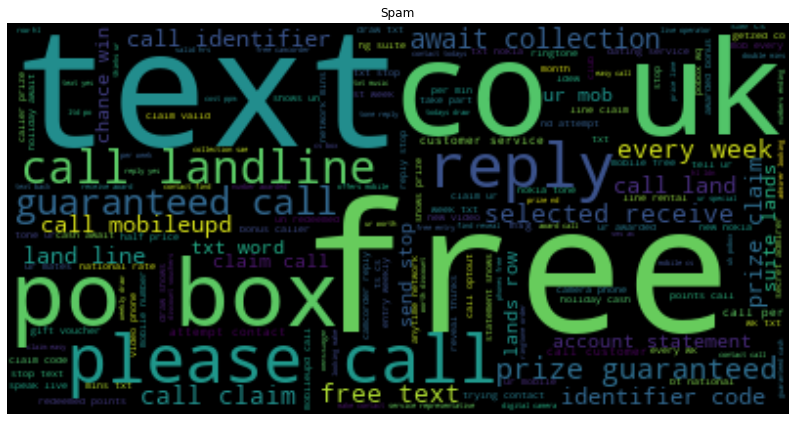

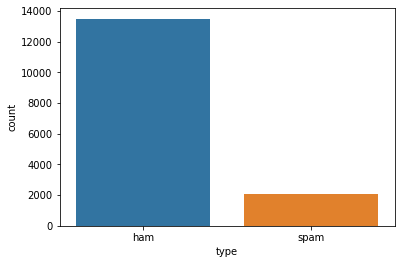

In [20]:
#Getting specific labels for visualization. Spam=1, Ham=0
spam = preprocessed_train_data[preprocessed_train_data.class_label==1]
ham = preprocessed_train_data[preprocessed_train_data.class_label==0]
  
def visualize(label,data):
    """Visualize pre-processed data by means of WordCloud and Countplot.
    
    Parameters
    ----------
        label:
            Label that specifies whether the data is spam or ham.
        data:
            Input dataframe.
            
    Returns
    -------
        None.
    """
    wordcloud = WordCloud().generate(''.join(label['text']))
    plt.figure(figsize=(14,12))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title("Spam")
    plt.axis('off')
    plt.show()
    sns.countplot(data.type)
    
visualize(spam,preprocessed_train_data)

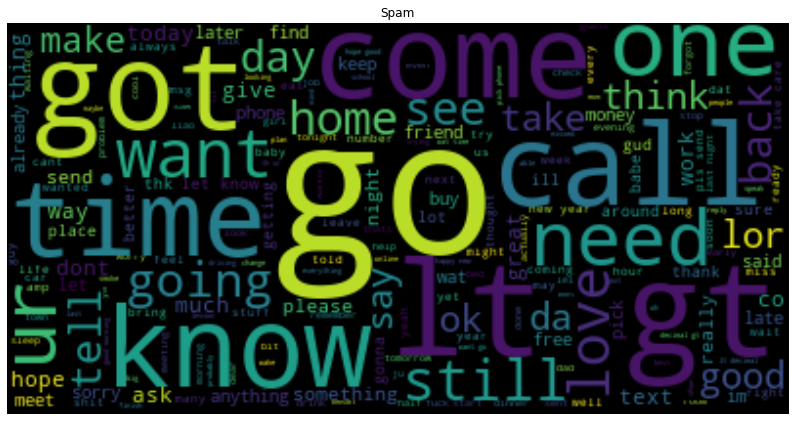

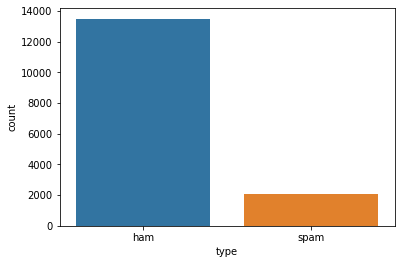

In [21]:
visualize(ham,preProcessed_training_data)

## Step 4:- Build, train and validate the classifer

### Training on supervised data (labelled data)

#### Use the data in order to build your own Naive Bayes classifier (You can either use existing Naive Bayes from sklearn or build your own). Build the classifier, train it and then validate. Provide your result in confusion matrix (use heatmap from seaborn) along with the classification report from sklearn. Validation accuracy should be around 99%.

In [22]:
# Splitting dataset into X and y.
X = preprocessed_train_data['text']
y = preprocessed_train_data['class_label']

# Creating train test split as 80% training data & 20% validation data
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2)

# Vectorizing the train data in order to be given into the model as input. 
vectorizer = CountVectorizer()
X_train_vects = vectorizer.fit_transform(x_train.values)

# Fitting the classifier.
classifier = MultinomialNB()
targets = y_train.values
classifier.fit(X_train_vects,targets)

#Predict using validation data by the classifier.
X_valid_vects = vectorizer.transform(x_valid)
predictions = classifier.predict(X_valid_vects)

In [23]:
def evaluate(y_test,pred):
    """Perform classifier's evaluation by comparing actual value and predicted value.
    
    Parameters
    ----------
        y_test:
            Actual value (y).
        pred:
            Predicted value (y').
            
    Returns
    -------
        None.
    """
    print("Accuracy: ",metrics.accuracy_score(y_test,pred))
    print("Classification report:",metrics.classification_report(y_test,pred))

#Evaluating the classfier with validation accuracy and report
evaluate(y_valid,predictions)

Accuracy:  0.9884541372674791
Classification report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2684
           1       0.95      0.97      0.96       434

    accuracy                           0.99      3118
   macro avg       0.97      0.98      0.98      3118
weighted avg       0.99      0.99      0.99      3118



### Confusion Matrix Plot

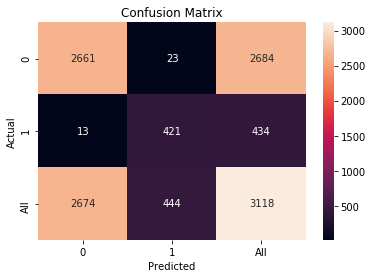

In [24]:
def plot_confusion_matrix(y,prediction):
    """Wrapper for plotting the confusion matrix to describe the performance of classifier.
    
    Parameters
    ----------
        y:
          Actual or true value.
        prediction:
            Classifier predicted values.
            
    Returns
    -------
        None.
    """
    confusion_matrix = metrics.confusion_matrix(y,prediction)
    df_confusion = pd.crosstab(y,prediction,rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.title("Confusion Matrix")
    sns.heatmap(df_confusion,annot=True,fmt='d')
    
plot_confusion_matrix(y_valid,predictions)

## Step 5:- Test the classifier

### Supervised classification

#### Test your Classifier using  the SMSSpamCollection.txt dataset provide a heatmap and classification report. Test accuracy should be around 99%.



In [25]:
# Test the classifier using labelled data
X_test1 = preprocessed_test_data1['text']
y_test1 = preprocessed_test_data1['class_label']

X_test1_vects = vectorizer.transform(X_test1)

# Predicting using test data
test_prediction1 = classifier.predict(X_test1_vects)

# Evaluating the test predictions
evaluate(y_test1,test_prediction1)

Accuracy:  0.9926417803302225
Classification report:               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4825
           1       0.96      0.98      0.97       747

    accuracy                           0.99      5572
   macro avg       0.98      0.99      0.98      5572
weighted avg       0.99      0.99      0.99      5572



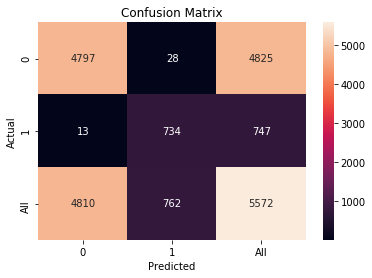

In [26]:
#Confusion matrix for test data
plot_confusion_matrix(y_test1,test_prediction1)

### Unsupervised classification

#### Test your Classifier using  the TestDataset.csv dataset. This dataset is not labelled so kindly predict the labels and visualise it.

Text(0.5, 0, 'Prediction')

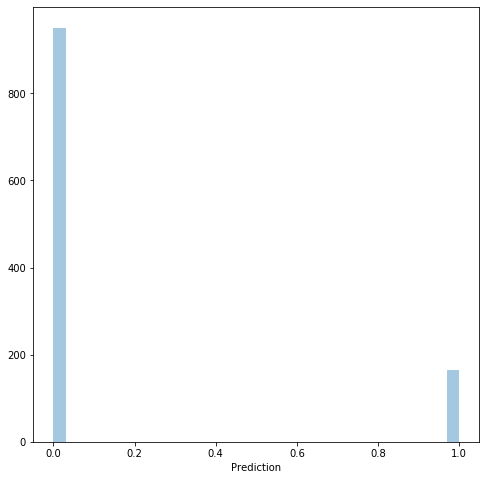

In [27]:
# Test the classifier using unlabelled data
X_test2 = preprocessed_test_data2['text']

X_test2_vects = vectorizer.transform(X_test2)

# Predicting the labels for unlabelled test set
test_prediction2 = classifier.predict(X_test2_vects)

#Plotting the results
plt.figure(figsize=(8,8))
sns.distplot(test_prediction2,kde=False)
plt.xlabel('Prediction')

## Step 6:- Cheat the classifier

#### Try to cheat the classifier by adding "good words" to the end of test dataset(TestDataset.csv) e.g:- Oh! no share Market has fallen down by $100,000 due to Corona outbreak... try mixing up spam and ham words see how the classifier works. Output the results in a good format to validate your work[15 points] 

,text,Predicted label
0,I got my claim back daaa,1
1,Can u send me ur gift voucher,1
2,i got a chance to win that prize...hopefully,1
3,Can u call me when u r free....,1
4,take a lucky dip,0
5,Please call your friends today,0


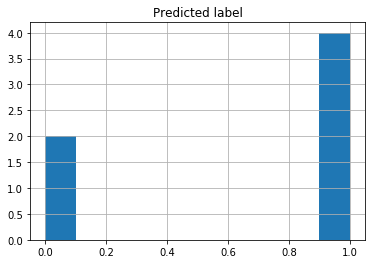

In [28]:
# Cheat the classifier
# New texts to be added to the test set
new_texts = [
            pd.Series(['I got my claim back daaa'],index=test_df2.columns),
            pd.Series(['Can u send me ur gift voucher'],test_df2.columns),
            pd.Series(['i got a chance to win that prize...hopefully'],index=test_df2.columns),
            pd.Series(['Can u call me when u r free....'],index=test_df2.columns),
            pd.Series(['take a lucky dip'],index=test_df2.columns),
            pd.Series(['Please call your friends today'],index=test_df2.columns)
            ]

# Adding new texts to the test dataframe
new_test_df2 = test_df2.append(new_texts,ignore_index=True)

preprocessed_test_data2_new = preProcessing(new_test_df2)

X_test2_vects_new = vectorizer.transform(preprocessed_test_data2_new['text'])

# Predicting labels for new test dataframe
test_prediction2_new = classifier.predict(X_test2_vects_new)

# Visualizing the predictions for newly added text only
result_df=pd.DataFrame(new_texts)
result_df.insert(1,"Predicted label",test_prediction2_new[-6:])
result_df.hist()
result_df

#### Write your analysis of how you intended to cheat the classifier and how it performed in few words (provide your inference)

**Analysis** <br>

To cheat the classifier, the way is to confuse it with mixture of both spam and ham words. The frequency of words(ham / spam) plays a vital role. If a word with high frequency or probability in spam/ham set is used in a sentence, the classifier can be cheated. <br>

**Eg. 1)**. In the above sentence -" I got my claim back daaa " -> Here, claim is a spam word with higher frequency, so when it is used in a sentence, the classifier predicts it as spam but the actual text is a ham. <br>

**2).** "Can u call me when u r free"  -> Here, the sentence is a ham but the classifier predicts it to be spam, as words like 'call' and 'free' are spam words. <br>

The same applies to the remaining sentences and this is a way to cheat the classifier. This may not be an optimal observation but just an inference.